In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from pandas.plotting import register_matplotlib_converters
sns.set(rc={'figure.figsize':(11.7,8.27)})
register_matplotlib_converters()

# Trendanalysis for temperature and percipitation

This notebook will aid in the search for a significant trend in temperature and percipitation data. Therefore the three nearest weather stations to the flood-area are connsidered (Bad Neuenahr-Ahrweiler, Koenigswinter-Heiderdorf, Koeln-Bonn Airport). Only the data concerning temperature and percipitation is read, for more information about the data please refer to [DWD-Documentation](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/monthly/kl/historical/DESCRIPTION_obsgermany_climate_monthly_kl_historical_en.pdf)

## Section 1: Use case

There are four questions I want to answer in this notebook:
1. Was there a trend in the temperatures leading up to this year?
2. Was there a trend in percipitation leading up to this year?
3. Are temperature and percipitation correlated closely enough to enable predictions?
4. If we can make predictions more advanced, would thoose predict this event?

## Section 2: Data understanding

The data is further described in the above emntioned documentation, but the data covers percipiation (mo_rr), and the mean of each days minimal, average and maximal temperature (mo_tn, mo_tt and mo_tx). The dataset covers a period from 1957 to 2020 in a monthly fashion, where "MESS_DATUM_BEGINN" represents the begin of each month

In [2]:
columns_to_read = ["STATIONS_ID", "MESS_DATUM_BEGINN", "MO_RR", "MO_TN", "MO_TT", "MO_TX"]
data_neuenahr = pd.read_csv("Data/month_3490.txt", sep=";", usecols=columns_to_read)
data_koenigswinter = pd.read_csv("Data/month_603.txt", sep=";", usecols=columns_to_read)
data_koeln = pd.read_csv("Data/month_2667.txt", sep=";", usecols=columns_to_read)
data_koeln.describe()

,STATIONS_ID,MESS_DATUM_BEGINN,MO_TT,MO_TX,MO_TN,MO_RR
count,760.0,7.600000e+02,760.000000,760.000000,760.000000,760.000000
mean,2667.0,1.988897e+07,10.208961,14.711026,5.648553,66.733553
std,0.0,1.829524e+05,6.033079,7.057194,5.159482,35.622239
min,2667.0,1.957090e+07,-5.980000,-2.500000,-10.570000,1.600000
25%,2667.0,1.973068e+07,5.122500,8.417500,1.675000,41.250000
50%,2667.0,1.989045e+07,9.860000,14.805000,5.345000,60.950000
75%,2667.0,2.005023e+07,15.727500,21.012500,10.212500,84.925000
max,2667.0,2.020120e+07,23.330000,30.380000,16.040000,216.900000


## Section 3: Data preparation

Renaming of the columns for better usability. For more information on the abbreviations please refer to the above mentioned documentation
Drop all rows where percipitation is not present, as this is the main focus of the analysis. In this dataset values that are not known are marked with '-999.0'. Also all rows with percipitation < 0 are dropped, as this is not possible.
Next all relevant data columns are converted to the right data type. The date column is formated accordingly, to correctly display any plots

In [3]:
def prepare_data(df):
    # Rename columns to usable names
    df = df.rename({
        "MO_RR": "Percipitation", 
        "MO_TN": "MinmalTemperature", 
        "MO_TT": "AverageTemperature", 
        "MO_TX": "MaximalTemperature",
        "STATIONS_ID": "StationID",
        "MESS_DATUM_BEGINN": "BeginOfMonth"
    }, axis=1)
    # remove all rows that cannot contribute to the analysis into percipitation
    df = df.drop(df[df["Percipitation"]<0].index).dropna(subset=["Percipitation"])
    
    # Cast all value columns to numeric types
    df = df.astype({
        "Percipitation": "float64", 
        "MinmalTemperature": "float64", 
        "AverageTemperature": "float64", 
        "MaximalTemperature": "float64"
    })
    
    # Cast date column to datetime
    df["BeginOfMonth"] = pd.to_datetime(df["BeginOfMonth"], format="%Y%m%d")
    
    return df

In [4]:
data_neuenahr = prepare_data(data_neuenahr)
data_koenigswinter = prepare_data(data_koenigswinter)
data_koeln = prepare_data(data_koeln)
data_neuenahr.head()

,StationID,BeginOfMonth,AverageTemperature,MaximalTemperature,MinmalTemperature,Percipitation
14,3490,1931-01-01,3.1,-999.0,0.2,78.4
15,3490,1931-02-01,0.5,-999.0,-3.3,54.2
16,3490,1931-03-01,2.4,-999.0,-3.1,8.3
17,3490,1931-04-01,7.1,-999.0,1.8,69.9
18,3490,1931-05-01,15.2,-999.0,8.8,109.5


Lastly the data is combined into one dataframe for easier plotting and analysis

In [5]:
full_data = pd.merge(data_neuenahr.drop("StationID", axis=1), data_koenigswinter.drop("StationID", axis=1), how ="outer", on="BeginOfMonth", suffixes=("_neuenahr", "_koenigswinter"))
full_data = pd.merge(full_data, data_koeln.drop("StationID", axis=1), how ="outer", on="BeginOfMonth", suffixes=("", "_koeln"))
full_data = full_data.rename({"AverageTemperature": "AverageTemperature_koeln", 
                              "MaximalTemperature": "MaximalTemperature_koeln", 
                              "MinmalTemperature": "MinmalTemperature_koeln",
                              "Percipitation": "Percipitation_koeln"
                             }, axis=1)
full_data.head()

,BeginOfMonth,AverageTemperature_neuenahr,MaximalTemperature_neuenahr,MinmalTemperature_neuenahr,Percipitation_neuenahr,AverageTemperature_koenigswinter,MaximalTemperature_koenigswinter,MinmalTemperature_koenigswinter,Percipitation_koenigswinter,AverageTemperature_koeln,MaximalTemperature_koeln,MinmalTemperature_koeln,Percipitation_koeln
0,1931-01-01,3.1,-999.0,0.2,78.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1931-02-01,0.5,-999.0,-3.3,54.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1931-03-01,2.4,-999.0,-3.1,8.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1931-04-01,7.1,-999.0,1.8,69.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1931-05-01,15.2,-999.0,8.8,109.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


For building a predictive model more recent data is needed, as the monthly aggregates are only available up to the end of 2020. So we will use the recent dataset for any prediction and resample it to a monthly frequency

In [6]:
recent_neuenahr = pd.read_csv("Data/recent_3490.txt", sep=";", usecols=["MESS_DATUM", " TXK", " TNK", " TGK"])
recent_neuenahr = recent_neuenahr.rename({ 
        " TNK": "MinmalTemperature_neuenahr", 
        " TGK": "AverageTemperature_neuenahr", 
        " TXK": "MaximalTemperature_neuenahr",
        "MESS_DATUM": "Date"
    }, axis=1)
recent_neuenahr = recent_neuenahr.astype({
        "MinmalTemperature_neuenahr": "float64", 
        "AverageTemperature_neuenahr": "float64", 
        "MaximalTemperature_neuenahr": "float64"
    })

# Cast date column to datetime
recent_neuenahr["Date"] = pd.to_datetime(recent_neuenahr["Date"], format="%Y%m%d")
recent_neuenahr = recent_neuenahr.set_index("Date").resample("M").mean().reset_index()
recent_neuenahr.tail()

,Date,MaximalTemperature_neuenahr,MinmalTemperature_neuenahr,AverageTemperature_neuenahr
12,2021-03-31,12.103226,1.364516,-0.703226
13,2021-04-30,12.686667,1.620000,-0.373333
14,2021-05-31,17.390323,5.987097,3.870968
15,2021-06-30,25.353333,13.946667,13.010000
16,2021-07-31,22.514286,13.314286,12.442857


## Section 4: Modeling

In [7]:
data = full_data.replace(-999.0, np.NaN).dropna(subset=["Percipitation_neuenahr"])[[
    "BeginOfMonth",
    "Percipitation_neuenahr",
    "AverageTemperature_neuenahr",
    "MaximalTemperature_neuenahr",
    "MinmalTemperature_neuenahr"
]].copy()
data = data[data["BeginOfMonth"]>pd.to_datetime("01/01/1970")]

In [8]:
# Check for missing data
for col in data.columns:
    if data[col].isnull().sum() > 0:
        print(data[data[col].isnull()])

    BeginOfMonth  Percipitation_neuenahr  AverageTemperature_neuenahr  \
902   2008-05-01                    40.7                          NaN   

     MaximalTemperature_neuenahr  MinmalTemperature_neuenahr  
902                        22.13                        9.62  


As there is only one row with a missing temperature, we can feel comfortable to drop the row, without impacting model perfomance

In [9]:
data = data.dropna(how="any")

Now we split the dataset into train and test dataset

In [10]:
X = data[["AverageTemperature_neuenahr",
          "MaximalTemperature_neuenahr",
          "MinmalTemperature_neuenahr"
         ]]
y = data[["Percipitation_neuenahr"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
lm = LinearRegression()
lm = lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)
r2_score(y_test, y_pred)

0.25457309254028504

As expected the predictive power of the model is quite bad, so we can't expect any real tangible predictions.

As expected the predictions fail to predict the huge amount of percipitation. This will likely be due to the poor predictive of the model. But it does show again, that an accurate prediction in the weeks before seems to be very difficult

In [12]:
lm.coef_

array([[-2.00136567, -5.9150435 , 11.5077444 ]])

----------------------------------

## Section 5: Evaluation

### 1. Was there a trend in the temperatures leading up to this year?

To answer the first will look at the monthy average temperature. It would be expected that you can make out a clear trend according with the known research in climate change and global warming

[Text(0, 0.5, 'Time'), Text(0.5, 0, 'Temperature in °C')]

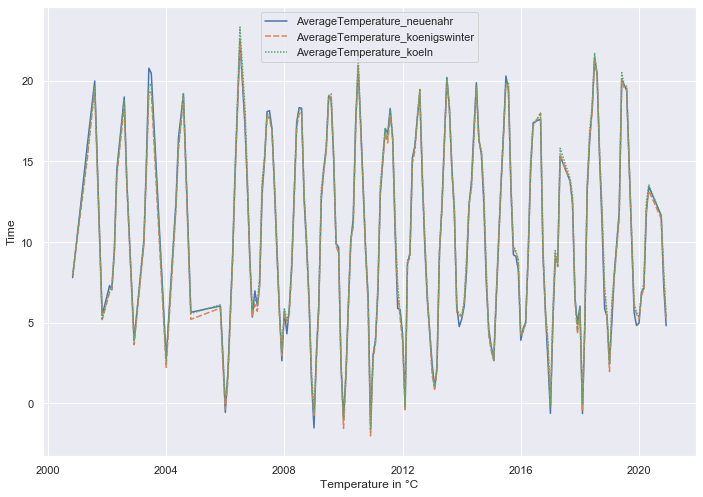

In [13]:
data = full_data[(full_data["BeginOfMonth"]>pd.to_datetime("01/01/1970"))].set_index("BeginOfMonth")[["AverageTemperature_neuenahr", "AverageTemperature_koenigswinter", "AverageTemperature_koeln"]]
data = data[(data["AverageTemperature_neuenahr"]>-999.0)&(data["AverageTemperature_koenigswinter"]>-999.0)]
ax = sns.lineplot(data=data)
ax.set(xlabel='Temperature in °C', ylabel='Time')

The plot shows two things simultaniously:
- The temperatures between the threee stations are very close
- There is no clear trend visible

To futher investigate we will look at the highest temperature recorded for one month. We will aggregate to a yearly level. As the temperature at the three stations don't seem to differ by much, we will focus on one station, the nearest one in Bad Neuenahr-Ahrweiler

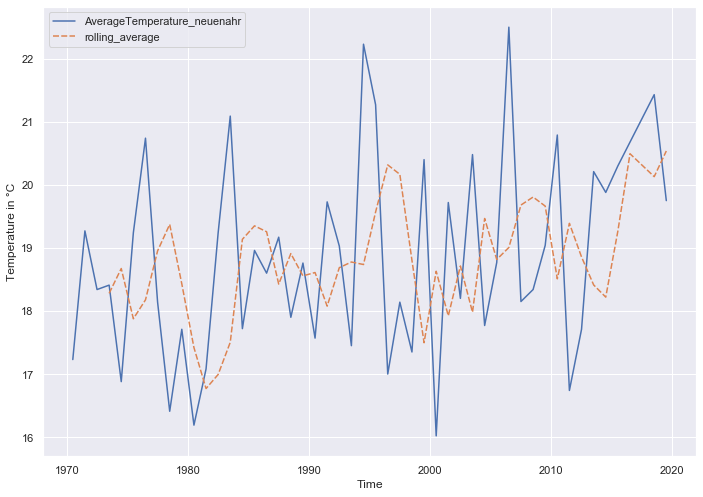

In [14]:
tmp_data = full_data[(full_data["BeginOfMonth"]>pd.to_datetime("01/01/1970"))&(full_data["BeginOfMonth"].dt.month==pd.to_datetime("07/01/1970").month)].set_index("BeginOfMonth")
tmp_data = tmp_data[["AverageTemperature_neuenahr"]]
tmp_data["rolling_average"] = tmp_data[["AverageTemperature_neuenahr"]].rolling(3).mean().shift(1)
ax = sns.lineplot(data=tmp_data)
ax.set(ylabel='Temperature in °C', xlabel='Time')
ax.figure.savefig("temperture_trend.png")

The plot shows that indeed there is a general trend towards higher temperature, as would be suggested by the research into climate change. Another detail of note for the analysis at hand ist that in the years leading up to the flood the temperature was rising in the summer months.

### 2. Was there a trend in percipitation leading up to this year?

For a better understanding of how the percipitation developed over the years, let's look at the percipitation in the months june and july. The month of june should be included, because if much percipitation meets dry land, the chances for flooding are said to rise.

For the same reasons as in the case for temperature we will focus on the station in Bad Neuenahr-Ahrweiler, as the data from all three stations is not really different

In [15]:
perc_data = full_data.copy()
perc_data = perc_data[perc_data["BeginOfMonth"]>pd.to_datetime("01/01/1970")]
perc_data = perc_data[(full_data["BeginOfMonth"].dt.month==pd.to_datetime("07/01/1970").month)|(full_data["BeginOfMonth"].dt.month==pd.to_datetime("06/01/1970").month)]
perc_data = perc_data.set_index("BeginOfMonth").resample("Y").sum()
perc_data = perc_data[["Percipitation_neuenahr"]]
perc_data["rolling_average"] = perc_data.rolling(3).mean().shift(1)

C:\Users\NHG\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


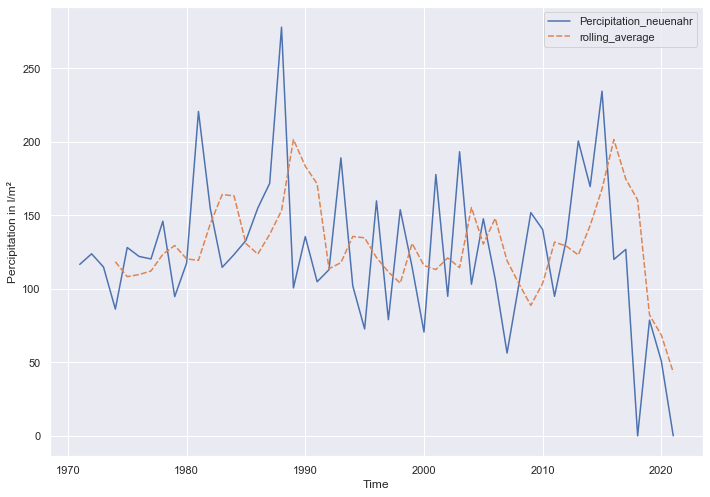

In [16]:
ax = sns.lineplot(data=perc_data)
ax.set(ylabel='Percipitation in l/m²', xlabel='Time')
ax.figure.savefig("percipitation_trend.png")

The above plot shows that additionally to being unusually warm, the years leading up to 2021 have been unusually dry as well. This also suggests that the land was dry to begin with and the heavy rain met an area that was not prepared to cope with the amount of water

### 3. Are temperature and percipitation correlated closely enough to enable predictions?

After seeing that there has been a buildup in the years before the flood, let's see if there is a correlation between the temperature and the percipitation in a month

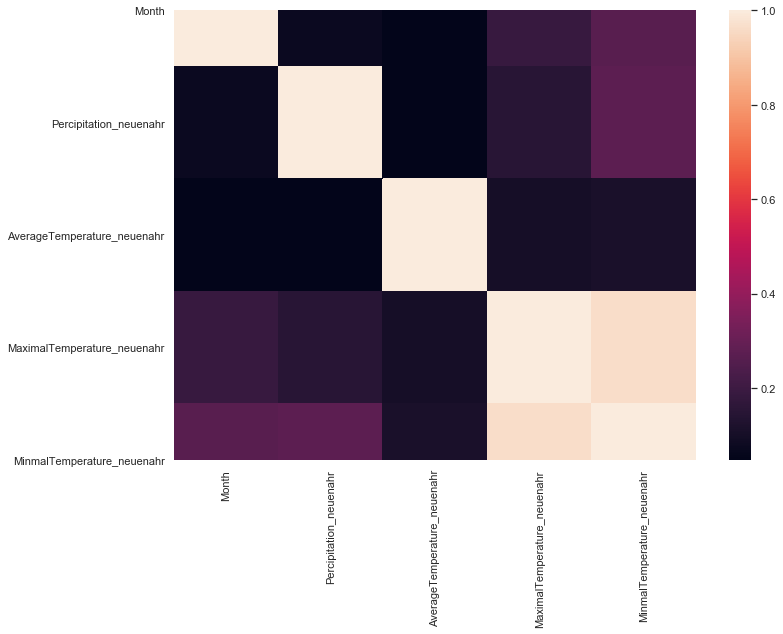

In [18]:
corr_data = full_data.copy()
corr_data["Month"] = corr_data["BeginOfMonth"].dt.month
corr = corr_data[corr_data["BeginOfMonth"]>pd.to_datetime("01/01/1970")][[
    "Month",
    "Percipitation_neuenahr",
    "AverageTemperature_neuenahr",
    "MaximalTemperature_neuenahr",
    "MinmalTemperature_neuenahr"
]].corr()

ax = sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
ax.figure.savefig("correlations.png")

Despite there not being a strong correlation between the temperature indicators and the preipitation, there seems to be some correlation between the minimal temperature and the monthly percipitation.

### 4. If we can make predictions more advanced, would thoose predict this event?

As we already saw in the modeling section the predictive power of the model is quite bad, but nonetheless let's look at the predictions:

In [20]:
recent_neuenahr.tail(2)

,Date,MaximalTemperature_neuenahr,MinmalTemperature_neuenahr,AverageTemperature_neuenahr
15,2021-06-30,25.353333,13.946667,13.010000
16,2021-07-31,22.514286,13.314286,12.442857


In [21]:
lm.predict(recent_neuenahr.drop("Date", axis=1).tail(2))

array([[113.04298521],
       [115.93898345]])

The predictions for june and july suggest a total percipitation of around 113 to 115 liters per square meter, but taking the bad performance into account this will not be of much impact to the discussion